In [119]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout


In [21]:
df = pd.read_csv("./dataset_fixeds.csv")
df['timeStamps'] = pd.to_datetime(df['timeStamps'])
df.set_index('timeStamps', inplace=True)


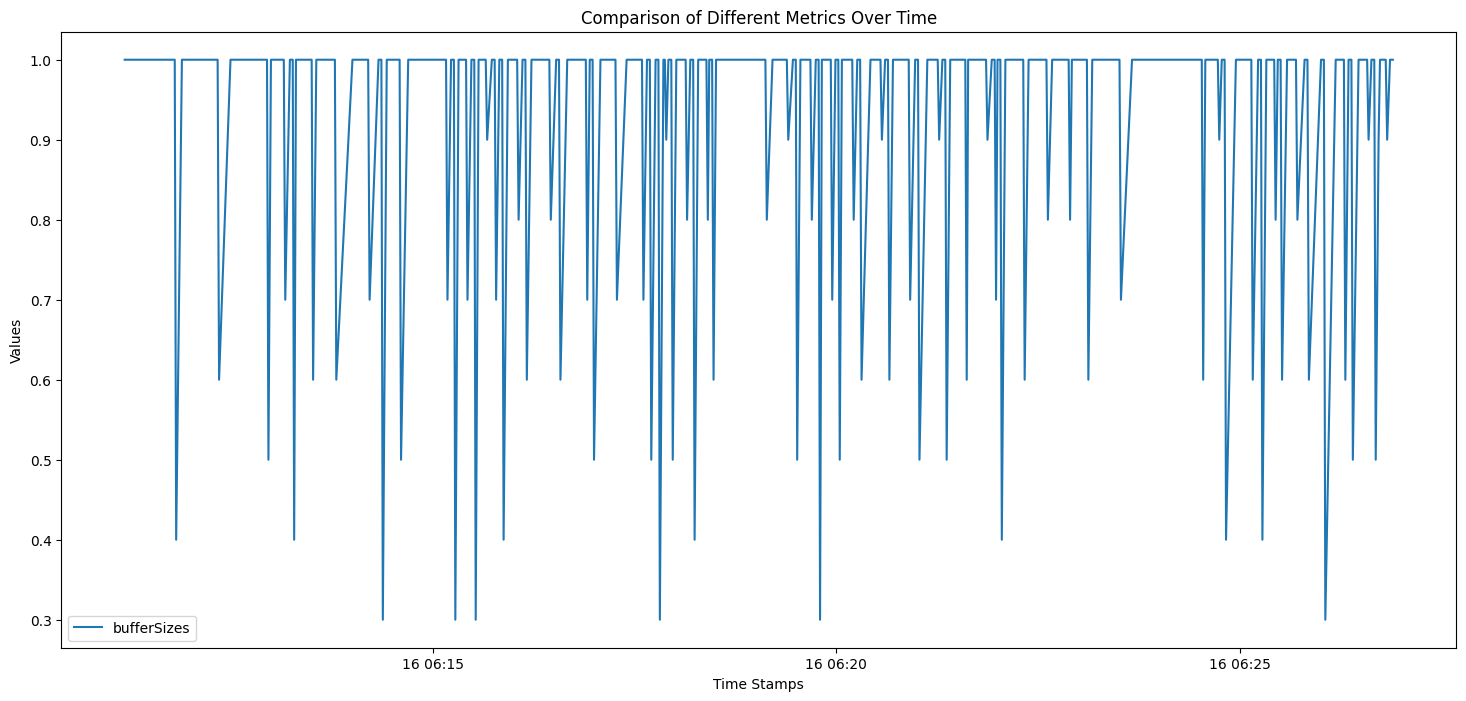

In [29]:
columns_to_plot = [ 'bufferSizes']

# Bikin plot buat setiap kolom
plt.figure(figsize=(18, 8))

for column in columns_to_plot:
    plt.plot(df.index, df[column], label=column)

# Tambah label dan judul
plt.xlabel('Time Stamps')
plt.ylabel('Values')
plt.title('Comparison of Different Metrics Over Time')
plt.legend()

# Tampilkan plot
plt.show()

In [42]:
features = df[['oldBitrates', 'streamBandwidths', 
                    'estimatedBandwidths', ]]
target = df['newBitrates']  # Target prediksi

In [113]:

# Scaling semua fitur ke range 0-1
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)

# Scaling target juga
scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Membagi data jadi training dan testing (70% training, 30% testing)
train_features, test_features, train_target, test_target = train_test_split(
    features_scaled, target_scaled, test_size=0.2, shuffle=False)

# Fungsi untuk membuat sequences (LSTM butuh data urutan)
def create_sequences(data, target, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = target[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Buat sequence dengan panjang 10 (misalnya)
sequence_length = 3
X_train, y_train = create_sequences(train_features, train_target, sequence_length)
X_test, y_test = create_sequences(test_features, test_target, sequence_length)

# Cek shape data hasil preprocessing
print(X_train.shape, y_train.shape) 
# Hasilnya harus dalam bentuk (samples, timesteps, features)

(467, 3, 2) (467, 1)


In [120]:
model = Sequential()

# Layer Conv1D buat nangkap pola lokal di data sekuensial
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

# Layer LSTM pertama
model.add(LSTM(128, activation="relu", return_sequences=True))
model.add(Dropout(0.3))

# Layer LSTM kedua (Bidirectional biar lebih kuat buat sekuensial data)
model.add(Bidirectional(LSTM(64, activation="relu", return_sequences=True)))
model.add(Dropout(0.3))

# Layer LSTM ketiga
model.add(LSTM(32, activation="relu"))
model.add(Dropout(0.2))

# Layer Dense buat output (di sini prediksi satu output)
model.add(Dense(1, activation='linear'))  # Aktivasi 'linear' cocok buat regresi

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')
# Lihat ringkasan model
model.summary()


d:\cursor_code\python\Lstm\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,721 (854.38 KB)

 Trainable params: 218,721 (854.38 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50,batch_size=3,callbacks=early_stopping,validation_split=0.1, validation_data=(X_test,y_test),verbose=1)

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0883 - val_loss: 0.0351
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0448 - val_loss: 0.0406
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0507 - val_loss: 0.0604
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0457 - val_loss: 0.0607
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0384 - val_loss: 0.0585
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0415 - val_loss: 0.0731


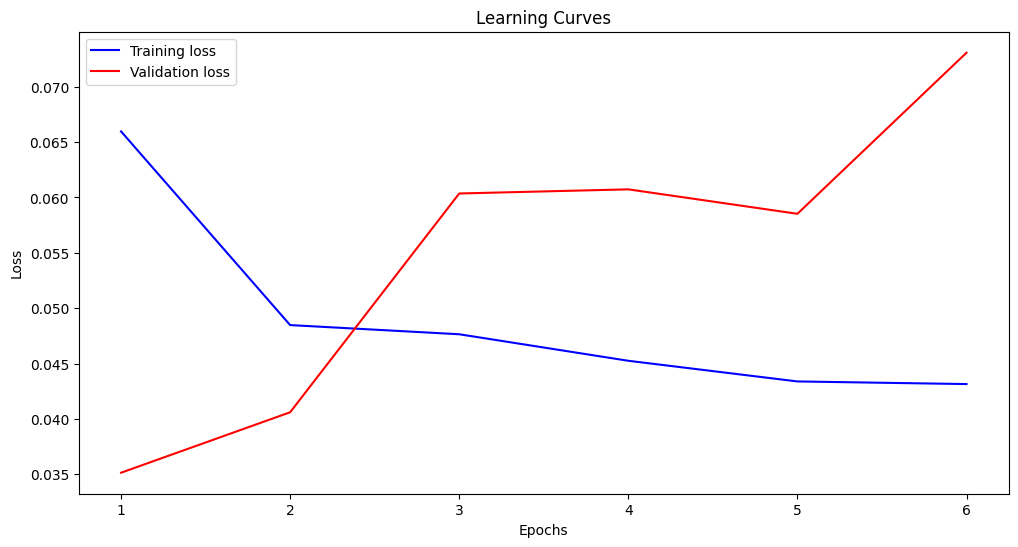

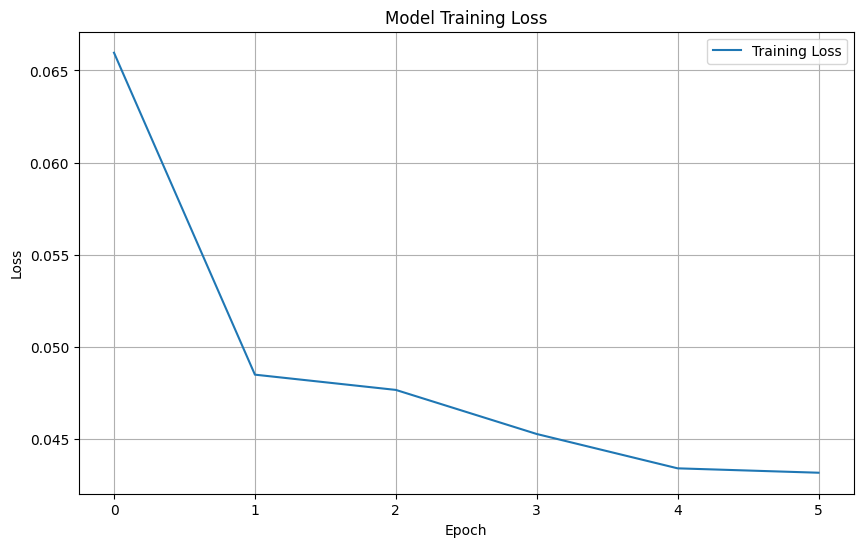

In [122]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


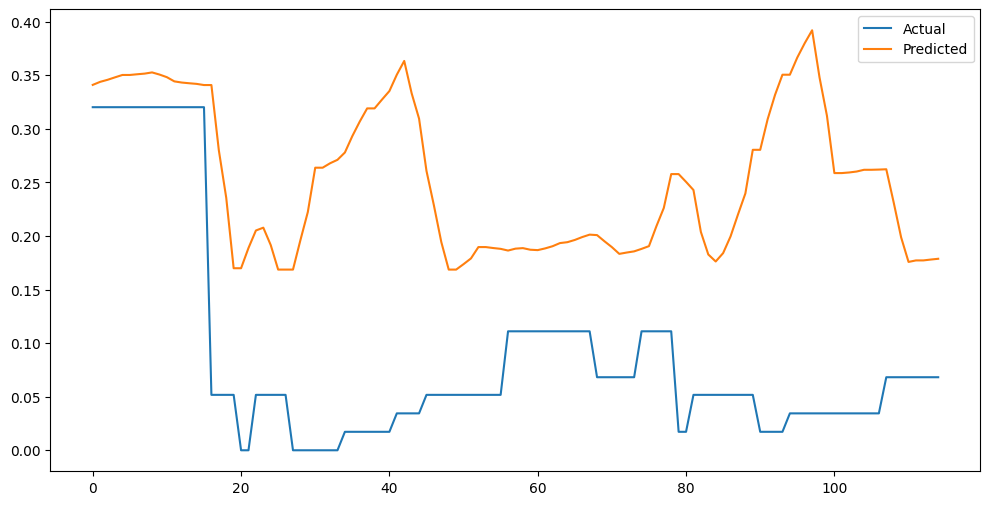

In [123]:
predictions = model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

r2 = r2_score(y_test, predictions)
r2


-6.346591210205638